# Initialization

In [370]:
import os
from pathlib import Path

import warnings

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc('figure', figsize=(6, 4.5))
mpl.rcParams['font.size'] = 10
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['hatch.linewidth'] = 0.5
mpl.rcParams['hatch.color'] = '0.25'

import xarray as xr

from scipy.special import erf
from numpy import pi as π

import smoothed_jet as Jet
UnsmoothedJet = Jet.UnsmoothedJet
SmoothedJet = Jet.SmoothedJet
JetForcingAndIC = Jet.JetForcingAndIC

In [371]:
# trig functions that take degrees

def sind(x):
    return np.sin(np.deg2rad(x))

def cosd(x):
    return np.cos(np.deg2rad(x))

In [372]:
import importlib
import sys
importlib.reload(sys.modules['smoothed_jet'])
import smoothed_jet as Jet
UnsmoothedJet = Jet.UnsmoothedJet
SmoothedJet = Jet.SmoothedJet
JetForcingAndIC = Jet.JetForcingAndIC

# Basic parameters

In [373]:
ic = JetForcingAndIC(central_lat=35,
                     length_scale=30,
                     delta = 0.3,
                     thicknesses=np.array([570, 1430, 3000]),
                     gprime=np.array([0.0159, 0.00223]),
                     transport=30,
                     Lx = 8000,
                     Ly = 3000,
                     dx = 5,
                     smoothing_scale=0.5
                    )
vars(ic)

{'L': 30,
 'δ': 0.3,
 'rho0': 1035,
 'profiles_initialized': True,
 'grid_initialized': True,
 'θ0': 35,
 'f0': 8.365170765045259e-05,
 'β': 1.8725238172659555e-11,
 'b': 0.006715429498787372,
 'H': array([ 570, 1430, 3000]),
 'K': 3,
 'gprime': array([9.80e+00, 1.59e-02, 2.23e-03]),
 'gbar': 0.015874244847645148,
 'F': array([[1.12743419e-03, 4.49396844e-04, 2.14212496e-04],
        [6.94896543e-01, 2.76986734e-01, 1.32030343e-01],
        [4.95464352e+00, 1.97492784e+00, 9.41382268e-01]]),
 'Umax': 0.8771929824561403,
 'ε': 0.3495417715087511,
 'l_nondim': 0.5,
 'l_dim': 15.0,
 'recenter': True,
 'rescale': True,
 'Ly': 3000,
 'Lx': 8000,
 'dx': 5,
 'dt': None,
 'jet': <smoothed_jet.SmoothedJet at 0x1ac98bd00>,
 'transport': 30.172610037612777,
 'NX': 1600,
 'NY': 600,
 'grid': <xarray.Dataset>
 Dimensions:  (xq: 1601, xh: 1600, yq: 601, yh: 600, zl: 3, zi: 4)
 Coordinates:
   * xq       (xq) float64 0.0 5.0 10.0 15.0 ... 7.99e+03 7.995e+03 8e+03
   * xh       (xh) float64 2.5 7.5 12

# Timestep

We pick a timestep that evenly divides a day, is larger than a given value, and produces a CFL less than a maximum value.

In [374]:
ic.suggest_timestep(400)

array([ 400,  432,  450,  480,  540,  576,  600,  640,  675,  720,  800,
        864,  900,  960, 1080, 1152, 1200, 1350])

In [375]:
ic.dt = 540

# Sponge

## Viscous

In [376]:
ic.viscosity_from_cfl(0.15)

ic.set_viscous_sponge(
    widthE=1600, rampE=200,
    widthW=0,    rampW=200,
    widthN=200,  rampN=200,
    widthS=200,  rampS=200,
)

namespace(initialized=True,
          Kh=1736.111111111111,
          widthN=200,
          rampN=200,
          widthS=200,
          rampS=200,
          widthE=1600,
          rampE=200,
          widthW=0,
          rampW=200,
          field_name='Kh')

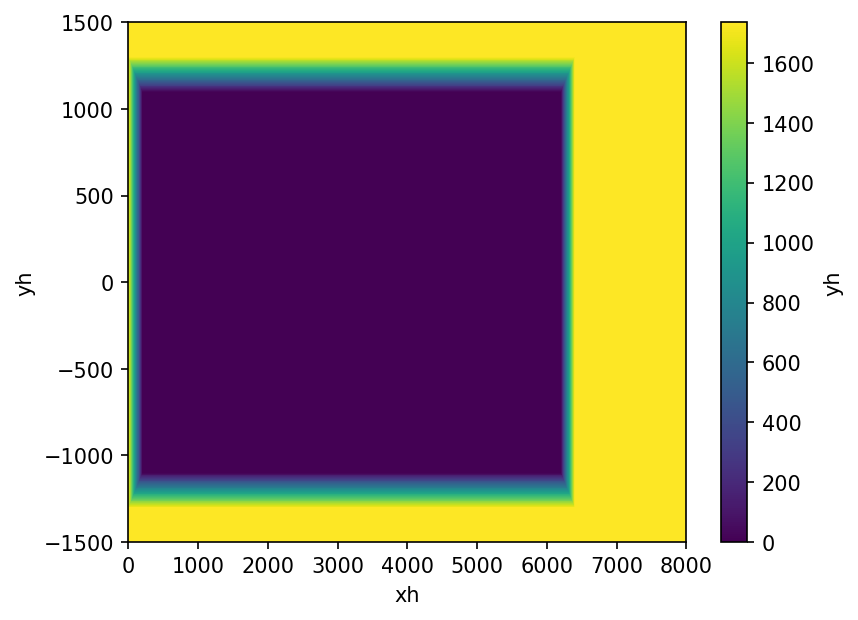

In [377]:
ic.viscous_sponge().plot()

## Velocity Relaxation

In [378]:
ic.set_relax_sponge_vel(
    widthW=400, rampW=200,
    widthE=0,   rampE=200,
    rlx_time=1
)

namespace(initialized=True,
          widthN=0,
          rampN=0,
          widthS=0,
          rampS=0,
          widthE=0,
          rampE=200,
          widthW=400,
          rampW=200,
          max_rate=1.1574074074074073e-05,
          field_name_u='Idamp_u',
          field_name_v='Idamp_v')

In [379]:
idamp_u, idamp_v = ic.relax_sponge_vel()

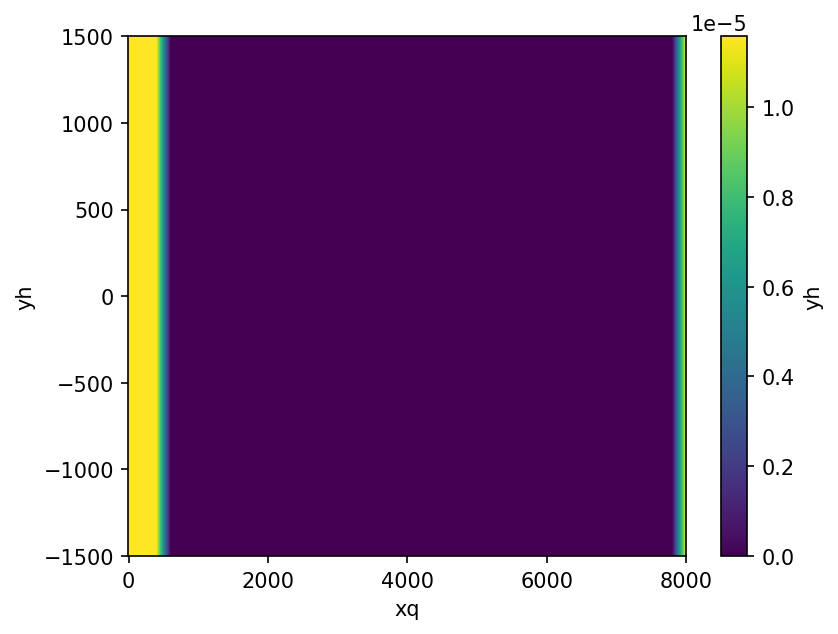

In [380]:
idamp_u.plot()

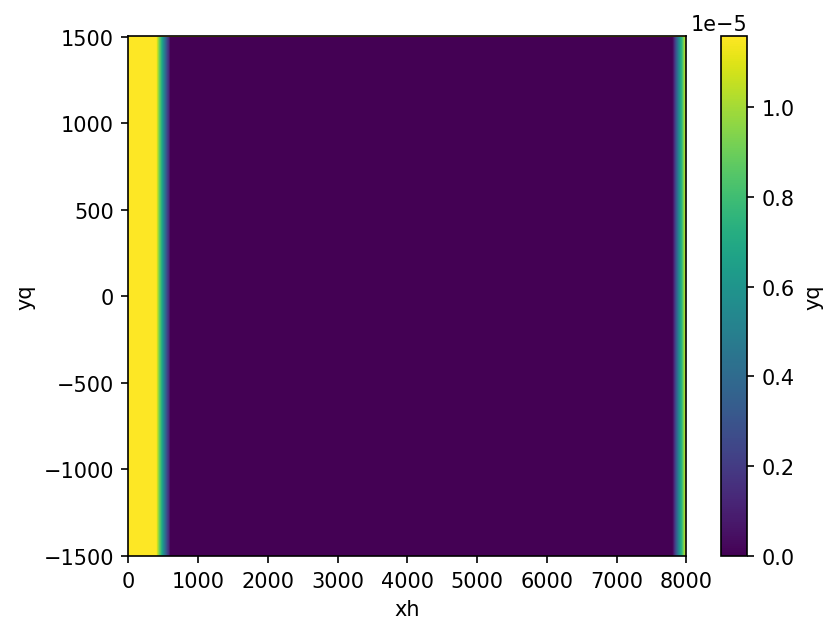

In [381]:
idamp_v.plot()

## Interface relaxation

In [382]:
ic.set_relax_sponge_eta(
    widthW=400, rampW=200,
    widthE=0,   rampE=200,
    rlx_time=30
)

namespace(initialized=True,
          widthN=0,
          rampN=0,
          widthS=0,
          rampS=0,
          widthE=0,
          rampE=200,
          widthW=400,
          rampW=200,
          max_rate=3.8580246913580245e-07,
          field_name_damp='Idamp_eta',
          field_name_target='eta_target')

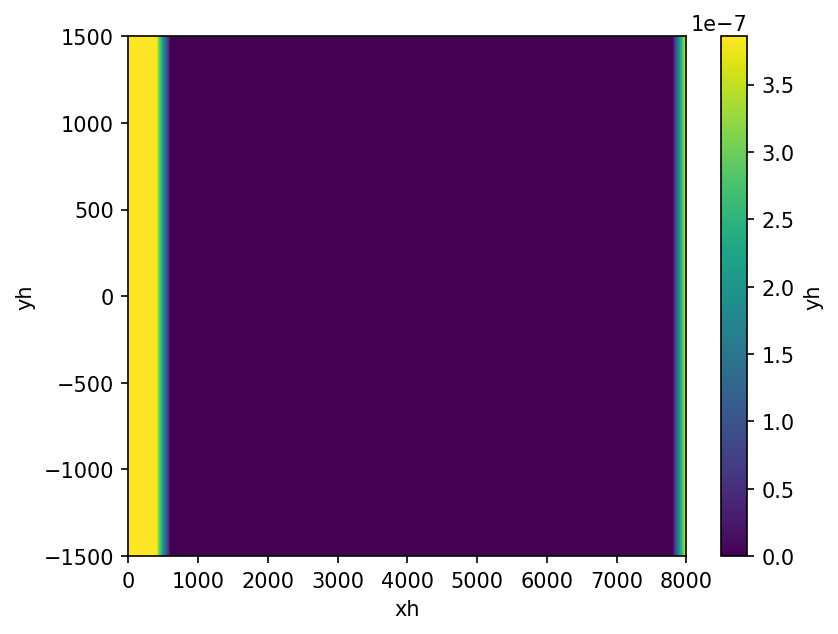

In [383]:
idamp = ic.relax_sponge_eta()
idamp.plot()

# Target and initial heights and velocity

## Target velocity

# Make input directory

In [384]:
expname = 'test'

target = os.path.join('..','{:d}layer'.format(ic.K), '{:g}km_dt{:04d}'.format(ic.dx, int(ic.dt)), expname)
Path(os.path.join(target, 'INPUT')).mkdir(exist_ok=True, parents=True)

print(target)

../3layer/5km_dt0540/test


## Fix up the override file

Either `MOM_override` should contain the following lines or `MOM_input` should have the equivalent lines without the "#override"

In [385]:
print('#override NIGLOBAL = {:d}'.format(ic.NX))
print('#override NJGLOBAL = {:d}'.format(ic.NY))
print('#override DT = {:d}'.format(ic.dt))
print('#override SOUTHLAT = {:.1f}'.format(-ic.Ly/2))
print('#override LENLAT = {:.1f}'.format(ic.Ly))
print('#override LENLON = {:.1f}'.format(ic.Lx))
print('#override F_0 = {:e}'.format(ic.f0))
print('#override BETA = {:e}'.format(ic.β))
print('#override NK = {:d}'.format(ic.K))

#override NIGLOBAL = 1600
#override NJGLOBAL = 600
#override DT = 540
#override SOUTHLAT = -1500.0
#override LENLAT = 3000.0
#override LENLON = 8000.0
#override F_0 = 8.365171e-05
#override BETA = 1.872524e-11
#override NK = 3


You should also make sure that there are approprate entries for spatially variable viscosity, velocity relaxation, and thickness relaxation (if using).

# Write out

In [387]:
ds = ic.to_xarray()
ds.to_netcdf(os.path.join(target, 'jet_ic.nc'))
ds

<xarray.Dataset>
Dimensions:     (xq: 1601, xh: 1600, yq: 601, yh: 600, zl: 3, zi: 4)
Coordinates:
  * xq          (xq) float64 0.0 5.0 10.0 15.0 ... 7.99e+03 7.995e+03 8e+03
  * xh          (xh) float64 2.5 7.5 12.5 17.5 ... 7.988e+03 7.992e+03 7.998e+03
  * yq          (yq) float64 -1.5e+03 -1.495e+03 -1.49e+03 ... 1.495e+03 1.5e+03
  * yh          (yh) float64 -1.498e+03 -1.492e+03 ... 1.492e+03 1.498e+03
  * zl          (zl) float64 1.035e+03 1.037e+03 1.037e+03
  * zi          (zi) float64 1.034e+03 1.036e+03 1.037e+03 1.037e+03
Data variables:
    u           (zl, yh, xq) float64 1.214e-12 1.214e-12 1.214e-12 ... 0.0 0.0
    v           (zl, yq, xh) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    eta         (zi, yh, xh) float64 0.2246 0.2246 0.2246 ... -5e+03 -5e+03
    Kh          (yh, xh) float64 1.736e+03 1.736e+03 ... 1.736e+03 1.736e+03
    Idamp_u     (yh, xq) float64 1.157e-05 1.157e-05 ... 1.128e-05 1.157e-05
    Idamp_v     (yq, xh) float64 1.157e-05 1.157e-05 ... 1.157e-05 1.157e-05
    Idamp_eta   (yh, xh) float64 3.858e-07 3.858e-07 ... 3.713e-07 3.81e-07
    eta_target  (zi, yh, xh) float64 0.0 0.0 0.0 0.0 ... -5e+03 -5e+03 -5e+03

# Some plots

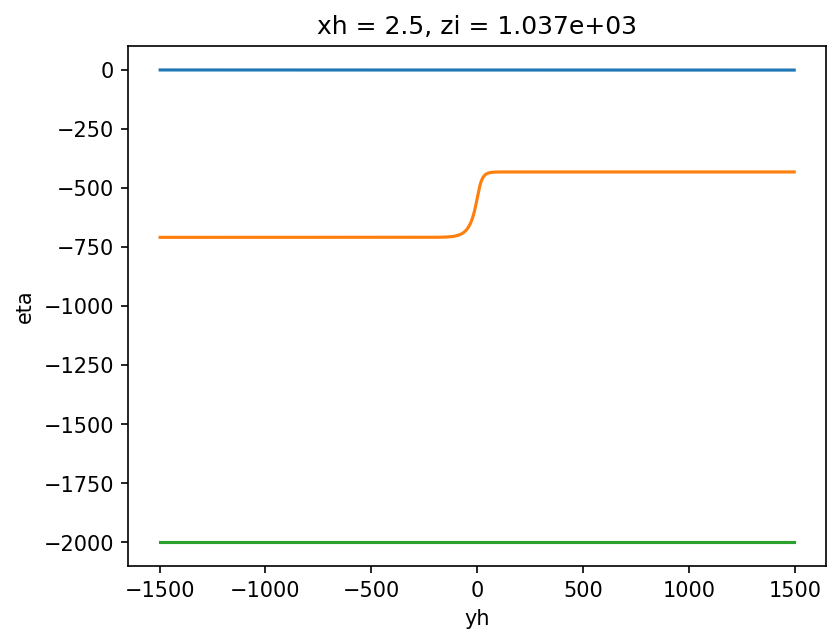

In [391]:
ds.eta.isel(xh=0, zi=0).plot()
ds.eta.isel(xh=0, zi=1).plot()
ds.eta.isel(xh=0, zi=2).plot()

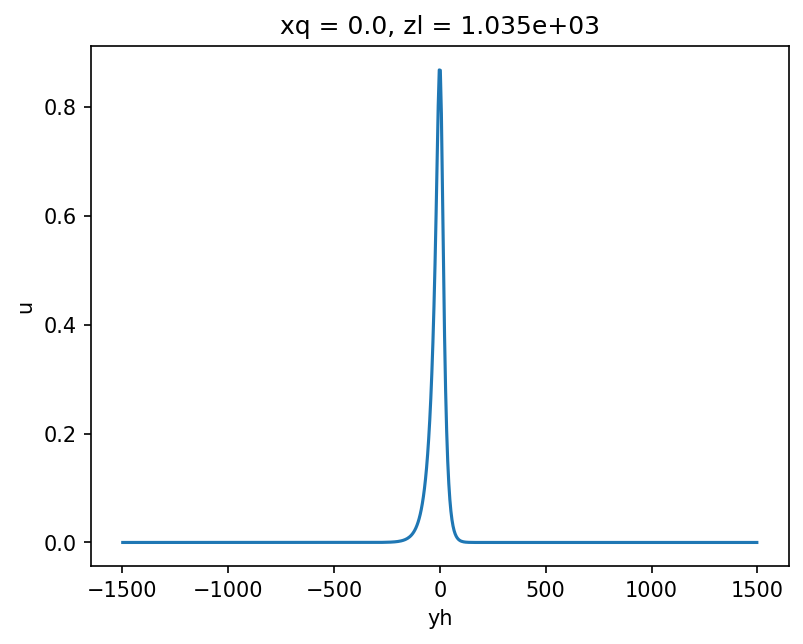

In [392]:
ds.u.isel(xq=0, zl=0).plot()